# A/B Testing - Spanish Translation 

## Import Data and Clean Data

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import data
df_test = pd.read_csv("test_table.csv")
df_user = pd.read_csv("user_table.csv")

In [3]:
#merge data based on user_id
df = df_test.merge(df_user,how = 'left',on = 'user_id')

In [11]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [12]:
df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


We can see that we have a lot of missing data on ads_channel, and some missing data about user info. It's ok for us to do the ab testing analysis this time.

In [39]:
# exclude data from Spain because our test this time is focus on any countries except spain
df1 = df[df['country']!= 'Spain']

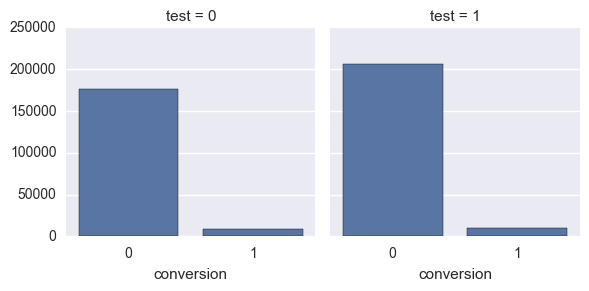

In [65]:
sns.FacetGrid(df1, col='test').map(sns.countplot,'conversion')

In the plot, we can not see much difference. Let's calculate step by step to see the ab test result.

## Sample Size Check

In [56]:
total_c = len(df1[df1.test == 0])
total_t = len(df1[df1.test == 1])
con_c = len(df1[(df1.test == 0) & (df1.conversion == 1)])
con_t = len(df1[(df1.test == 1) & (df1.conversion == 1)])
p_c = float(con_c)/total_c
p_t = float(con_t)/total_t

In [57]:
total_c

185311

In [59]:
total_t

215774

In [16]:
p_c

0.04833042316066309

In [17]:
p_t

0.043424713982118966

In [5]:
from scipy.stats import norm, zscore

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

def sample_power_difftest(d, s, power=0.8, sig=0.05):
    z = norm.isf([sig/2])
    zp = -1 * norm.isf([power])
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))



In [20]:
n = sample_power_probtest(p_c, p_t, power=0.8, sig=0.05)
print n  

28552


We only needed 28552 samples to make sure that our A/B test is valid. We have much more samples than 28552. So sample size check passed!

## Sanity Check for # of users

In [25]:
def sanity_check(control, test):
    observed = float(control)/(control + test)
    sd = np.sqrt((0.5*(1-0.5))/(control + test))
    upper = 0.5+1.96*sd
    lower = 0.5-1.96*sd
    if lower <= observed <= upper:
        print "Sanity Check Pass!"
        print "Observed is %.4f"%observed
        print "Confidence Interval is [%.4f,%.4f]" %(lower,upper)
    else:
        print "Sanity Check Fail!"
        print "Observed is %.4f"%observed
        print "Confidence Interval is [%.4f,%.4f]" %(lower,upper)

In [26]:
sanity_check(total_c,total_t)

Sanity Check Fail!
Observed is 0.4621
Confidence Interval is [0.4985,0.5015]


We do not know if we split the control and test group by 50/50. If that is the case, the sanity check for that failed.

## A/B Test Result Analysis

In [27]:
def abtest(total_c, total_t,con_c,con_t):
    p_c = float(con_c)/total_c
    p_t = float(con_t)/total_t
    p_pool = float(con_c + con_t)/(total_c + total_t)
    sd_pool = np.sqrt(p_pool*(1-p_pool)*(1.0/total_c+1.0/total_t))
    p_d = p_t - p_c
    z_score = p_d/sd_pool
    lower = p_d-1.96*sd_pool
    upper = p_d+1.96*sd_pool
    print "Z Score is %.4f"%z_score
    print "Confidence Interval is [%.4f,%.4f]" %(lower,upper)

In [28]:
abtest(total_c, total_t,con_c,con_t)

Z Score is -7.4220
Confidence Interval is [-0.0062,-0.0036]


Because the confidence interval do not contain 0, so this metric is statistically significant. In other word, if we change the translation for other spanish-speaking countries, the conversion rate will go down.

For this kind of situation, the reasons may be:
* Data is not enough - we already address that sample size is enough
* There are some bias when we collect the data - Let's take this approach!

## Investigation

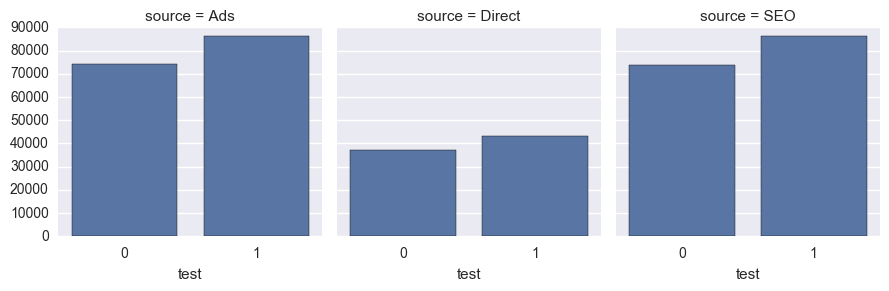

In [80]:
sns.FacetGrid(df, col='source').map(sns.countplot,'test')

The control/test split is good based on source.

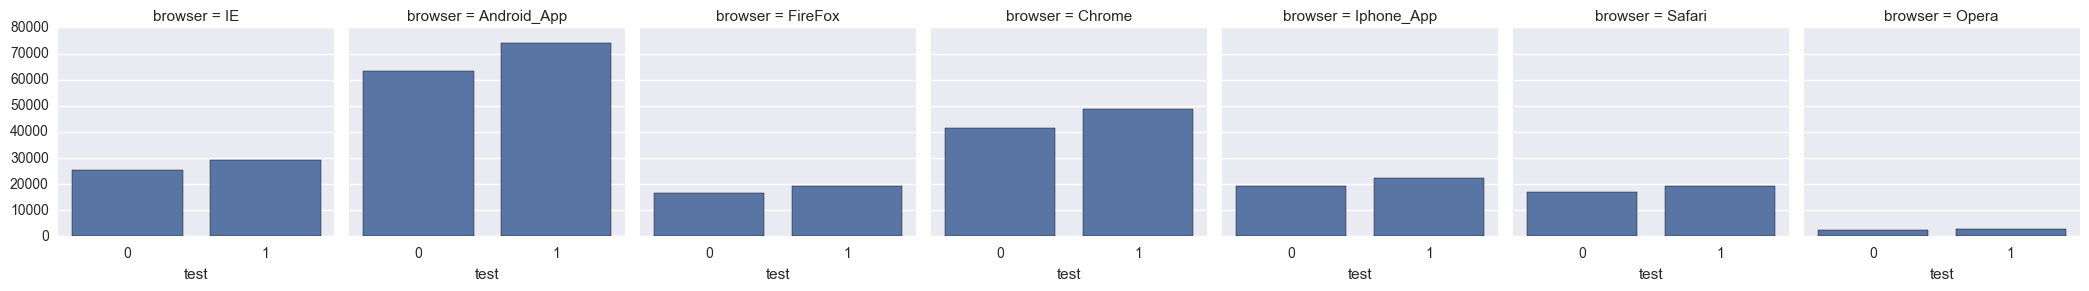

In [79]:
sns.FacetGrid(df, col='browser').map(sns.countplot,'test')

The control/test split is good based on browser.

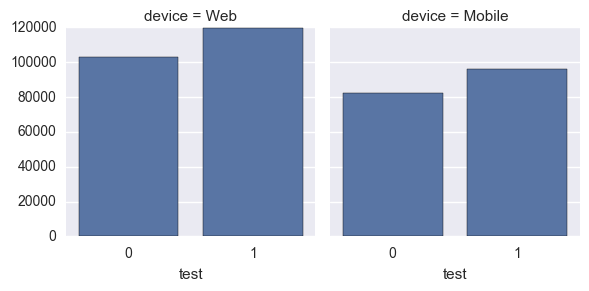

In [78]:
sns.FacetGrid(df, col='device').map(sns.countplot,'test')

The control/test split is good based on device.

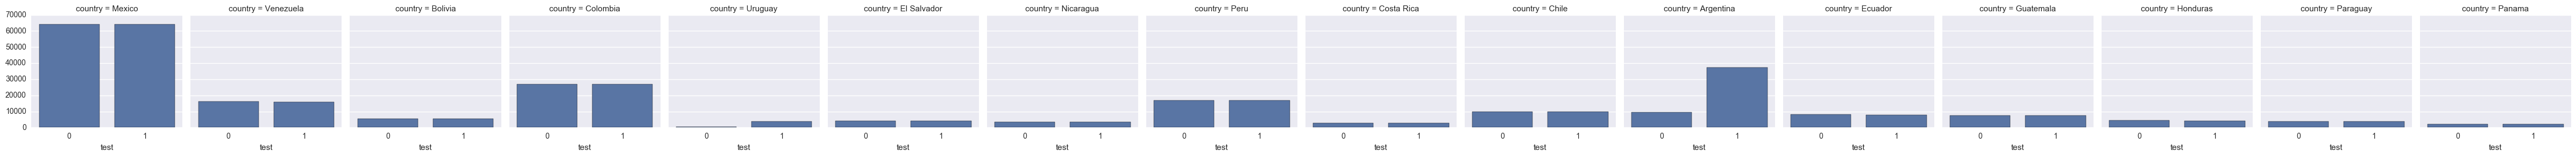

In [74]:
sns.FacetGrid(df, col='country').map(sns.countplot,'test')

Here is the problem! There are much more test users than control users in Argentina and Uruguay. This is unusual and that may result in huge bias to our test data. Now let's drop the NAs and see what will happen in each country.

In [51]:
df1 = df1[~df1['country'].isnull()] # drop NAN in dataset

In [52]:
df1.country.unique()

array(['Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Costa Rica', 'Chile',
       'Argentina', 'Ecuador', 'Guatemala', 'Honduras', 'Paraguay',
       'Panama'], dtype=object)

In [31]:
df_exc = df1[(df1['country']!= 'Argentina') & (df1['country']!= 'Uruguay') ]

In [32]:
total_c = len(df_exc[df_exc.test == 0])
total_t = len(df_exc[df_exc.test == 1])
con_c = len(df_exc[(df_exc.test == 0) & (df_exc.conversion == 1)])
con_t = len(df_exc[(df_exc.test == 1) & (df_exc.conversion == 1)])


In [33]:
abtest(total_c, total_t,con_c,con_t)

Z Score is 0.3181
Confidence Interval is [-0.0012,0.0017]


If we drop those two countries, the ab test result shows no satistically significance for the rest of test data. 

In [53]:
country = df1.country.unique()

In [54]:
for each in country:
    print each
    df_new = df[df['country']== each]
    abtest(len(df_new[df_new.test == 0]), len(df_new[df_new.test == 1]),
           len(df_new[(df_new.test == 0) & (df_new.conversion == 1)]), 
          len(df_new[(df_new.test == 1) & (df_new.conversion == 1)]))

Mexico
Z Score is 1.3867
Confidence Interval is [-0.0007,0.0041]
Venezuela
Z Score is -0.5626
Confidence Interval is [-0.0061,0.0034]
Bolivia
Z Score is -0.3600
Confidence Interval is [-0.0095,0.0065]
Colombia
Z Score is -0.8000
Confidence Interval is [-0.0052,0.0022]
Uruguay
Z Score is 0.1474
Confidence Interval is [-0.0106,0.0123]
El Salvador
Z Score is -1.1547
Confidence Interval is [-0.0151,0.0039]
Nicaragua
Z Score is 0.2789
Confidence Interval is [-0.0092,0.0123]
Peru
Z Score is 0.2898
Confidence Interval is [-0.0040,0.0054]
Costa Rica
Z Score is 0.4018
Confidence Interval is [-0.0096,0.0146]
Chile
Z Score is 1.0303
Confidence Interval is [-0.0029,0.0093]
Argentina
Z Score is -0.9909
Confidence Interval is [-0.0040,0.0013]
Ecuador
Z Score is -0.0483
Confidence Interval is [-0.0069,0.0066]
Guatemala
Z Score is -0.5649
Confidence Interval is [-0.0089,0.0049]
Honduras
Z Score is -0.7198
Confidence Interval is [-0.0125,0.0058]
Paraguay
Z Score is 0.1463
Confidence Interval is [-0.009

If we run test analysis for each country, we can see that there is no single one country shows statistical significance in this ab test. That is to say, change the translation for other spanish-speaking countries will not result in any change of conversion rate, either increase or decrease.